In [3]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torchvision import transforms
import torch
import onnx
from onnx2torch import convert
import random
import torch.nn as nn

from app.utils.dataset import DepthDataset, create_data_loader
from app.utils.env import Env
from models.train_depth_model import SILogLoss, BerHuLoss, evaluate
import numpy as np

In [41]:
env = Env()

image_size = 256
transform = transforms.Compose([
    transforms.Resize((256, 848)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 848)),
    transforms.ToTensor()
])

val_dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)

val_dataset_raw = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transforms.Compose([
        transforms.Resize((256, 848)),
        transforms.ToTensor()
    ]),
    target_transform=target_transform,
)

val_loader = create_data_loader(val_dataset, batch_size=16, shuffle=False)


# MiDaS

In [42]:
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\mkami/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\mkami/.cache\torch\hub\intel-isl_MiDaS_master


In [43]:
raw_image, depth_image = val_dataset[0]

raw_image_PIL = transforms.ToPILImage()(raw_image)

raw_np = np.array(raw_image_PIL)

In [44]:
input_tensor = transform(raw_np).to(device)

In [45]:
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=raw_np.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()
    

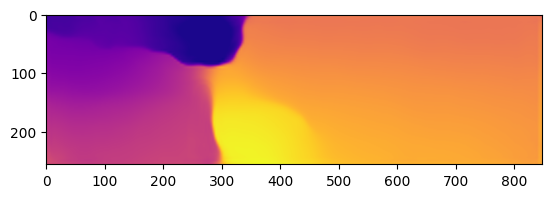

In [46]:
# show the prediction
plt.imshow(prediction, cmap='plasma')

In [52]:
import random
random.seed(23)

num_examples = 5
fig = plt.figure(figsize=(20, 5*num_examples))

for i in range(num_examples):

    idx = random.randint(0, len(val_dataset)-1)
    raw_image, depth_image = val_dataset[idx]
    raw_image_PIL = transforms.ToPILImage()(raw_image)
    raw_np = np.array(raw_image_PIL)

    input_tensor = transform(raw_np).to(device)


    with torch.no_grad():
        prediction = midas(input_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=raw_np.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()

    raw_image, _ = val_dataset_raw[idx]

    # apply mask

    mask = depth_image.squeeze().numpy() < 0
    print(depth_image.squeeze().min())
    prediction[mask] = -1
    break
    # prediction[~mask] = (prediction[~mask] - prediction[~mask].min()) / (
    #                 prediction[~mask].max() - prediction[~mask].min())
    # prediction[mask] = 0

    # depth_np = depth_image.squeeze().cpu().numpy()
    # depth_np[~mask] = (depth_np[~mask] - depth_np[~mask].min()) / (depth_np[~mask].max() - depth_np[~mask].min())
    # depth_np[mask] = 0


    ax = fig.add_subplot(num_examples, 3, i*3+1)
    ax.imshow(raw_image.squeeze().permute(1, 2, 0).cpu(), cmap='plasma')
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+2)
    ax.imshow(prediction, cmap='plasma')
    ax.set_title("MiDaS Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+3)
    ax.imshow(depth_np, cmap='plasma')
    ax.set_title("Ground Truth Depth")  
    ax.axis('off')

plt.tight_layout()
plt.show()



tensor(0.)


<Figure size 2000x2500 with 0 Axes>

# MonoVit
also known as DPT-Hybrid or Midas 3.0

In [11]:

env = Env()

image_size = 256
transform = transforms.Compose([
    transforms.Resize((256, 848)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 848)),
    transforms.ToTensor()
])

val_dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)

val_dataset_raw = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transforms.Compose([
        transforms.Resize((256, 848)),
        transforms.ToTensor()
    ]),
    target_transform=target_transform,
)

val_loader = create_data_loader(val_dataset, batch_size=16, shuffle=False)


In [12]:
from PIL import Image
import numpy as np
import requests
import torch

from transformers import DPTImageProcessor, DPTForDepthEstimation

image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)


In [26]:
raw_image, depth_image = val_dataset[0]
raw_image_PIL = transforms.ToPILImage()(raw_image)

raw_image, _ = val_dataset_raw[0]

In [15]:
# model.to(device)

In [27]:
inputs = image_processor(raw_image_PIL, return_tensors="pt")

In [28]:
inputs = {k: v.to(device) for k, v in inputs.items()}

In [29]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [30]:
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=raw_image_PIL.size[::-1],  # (height, width)
    mode="bicubic",
    align_corners=False
).squeeze().cpu().numpy()

In [31]:
depth_min = prediction.min()
depth_max = prediction.max()
normalized_depth = (prediction - depth_min) / (depth_max - depth_min)

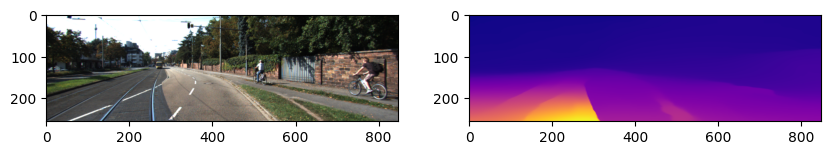

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.imshow(raw_image.squeeze().permute(1,2,0), cmap='plasma')
plt.subplot(1, 2, 2)
plt.imshow(normalized_depth, cmap='plasma')

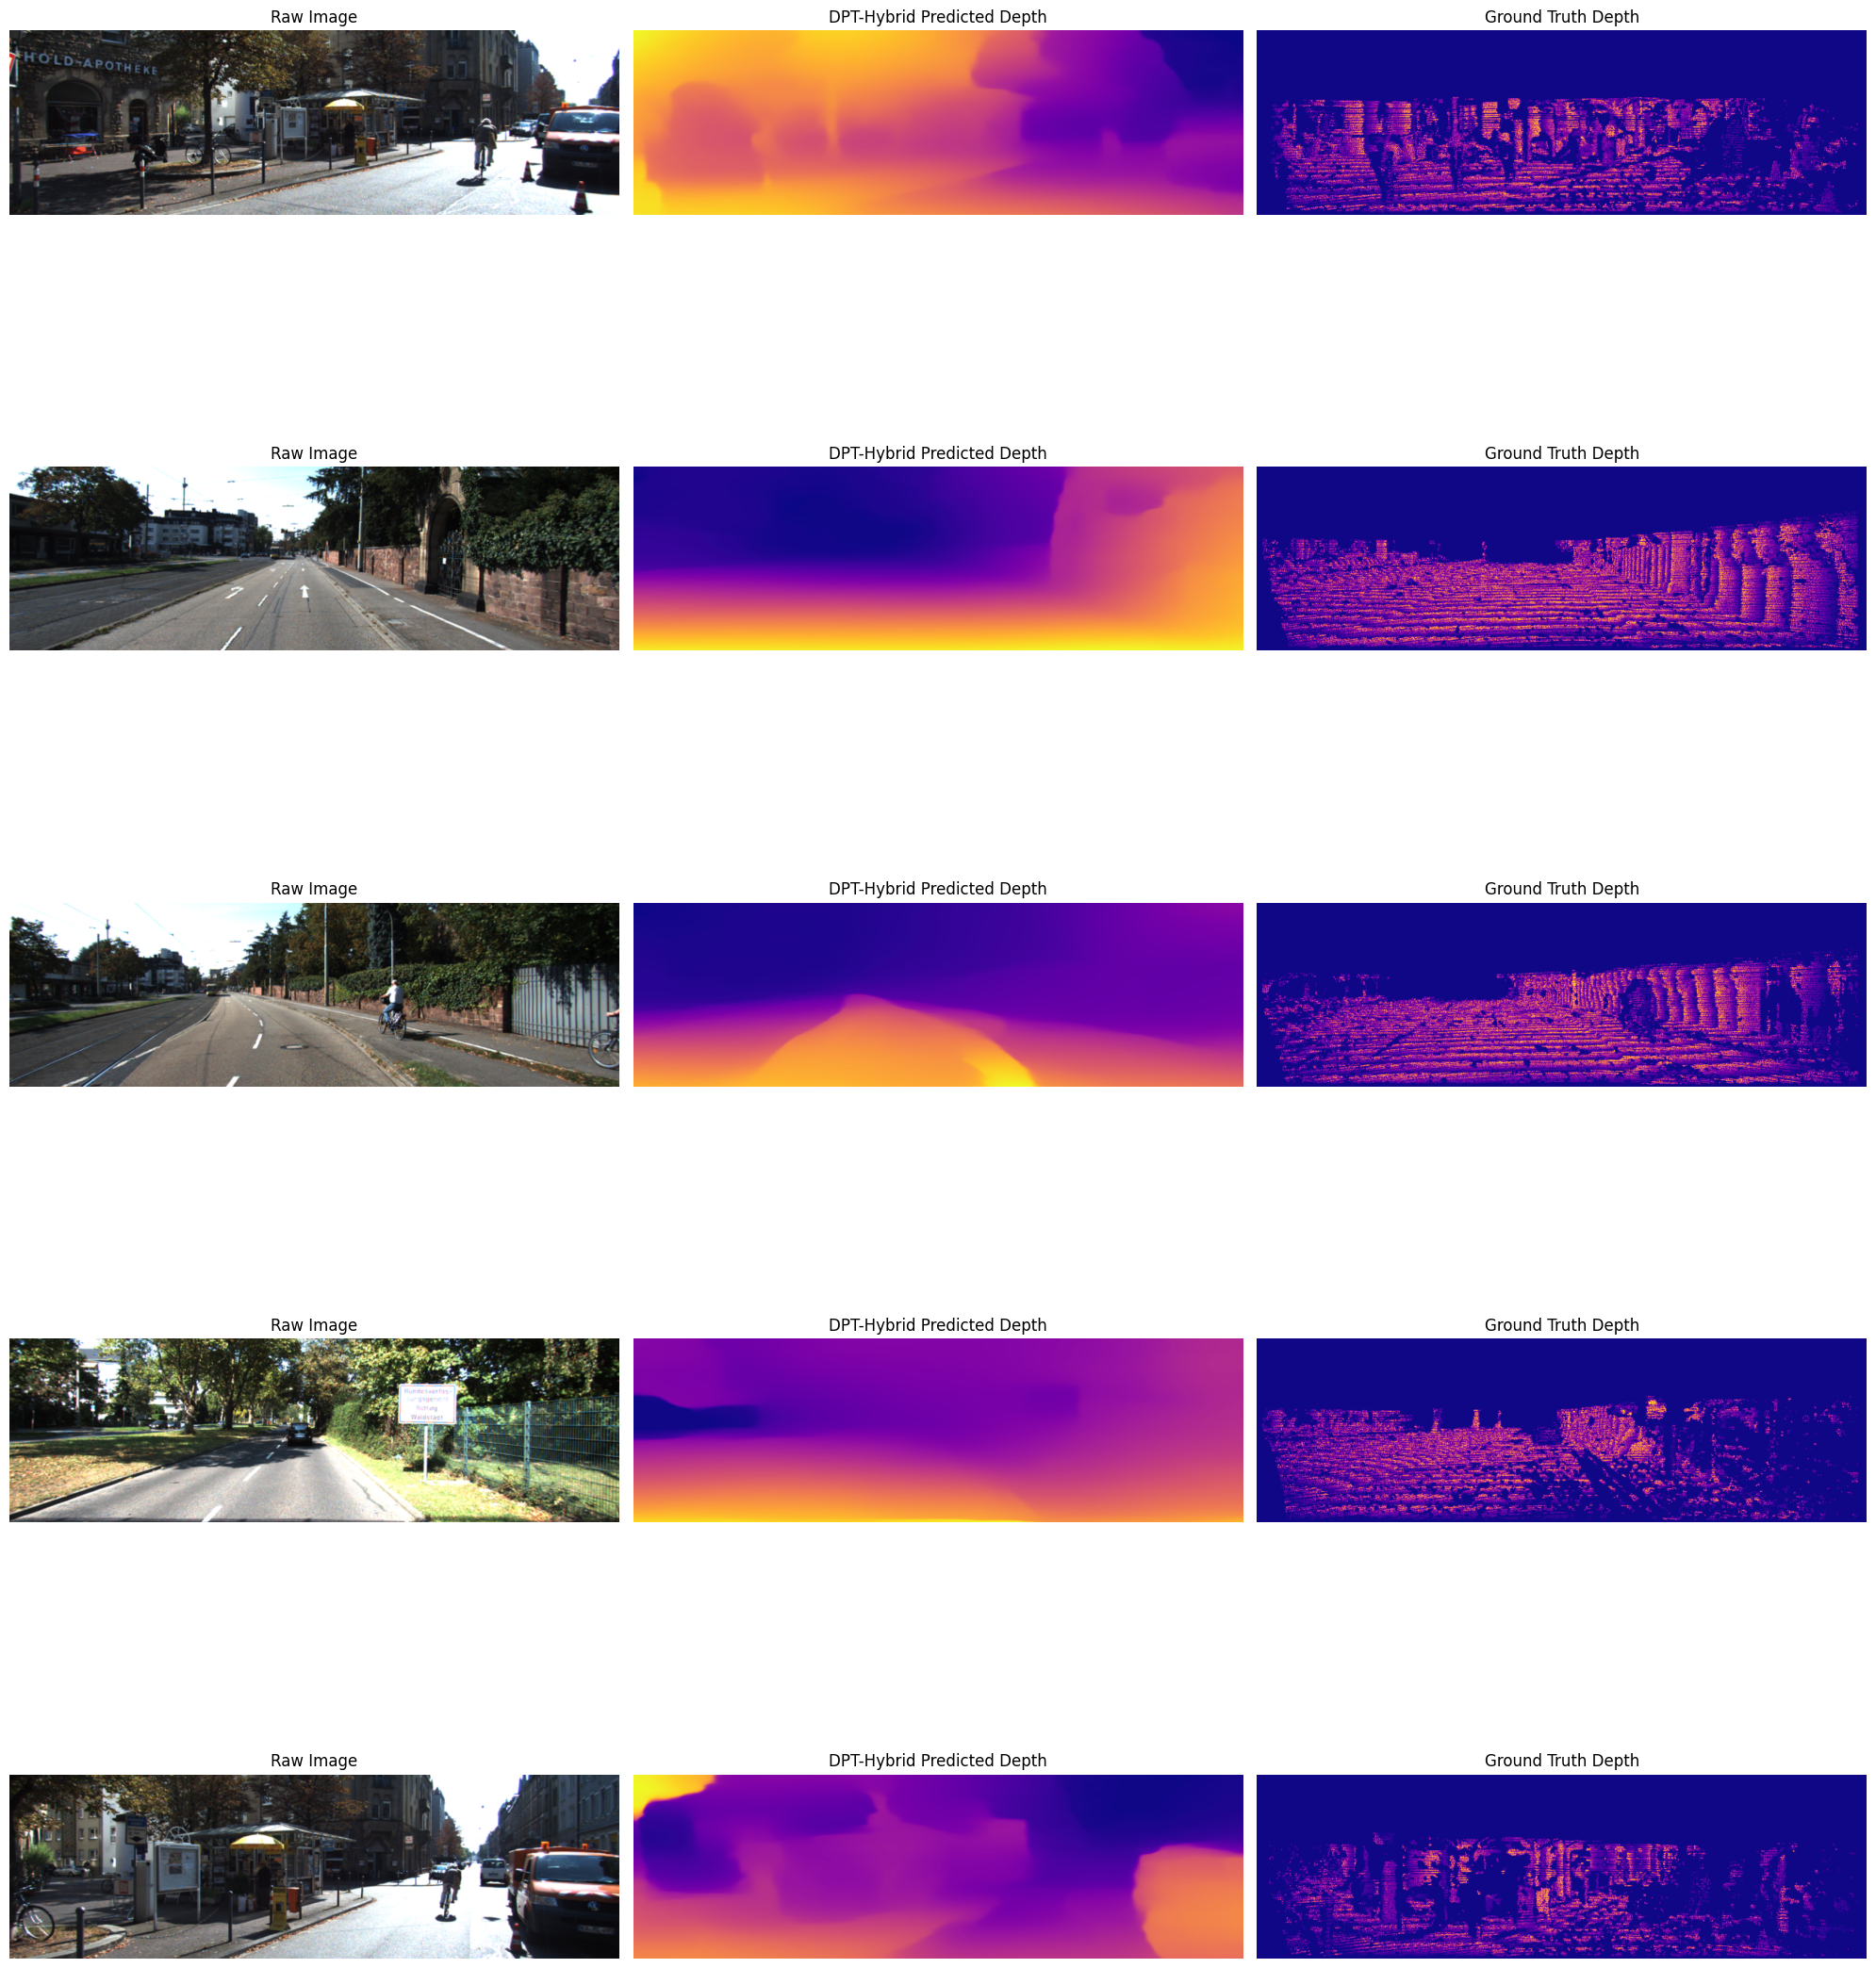

In [39]:
import random
random.seed(23)

num_examples = 5
fig = plt.figure(figsize=(20, 5*num_examples))

for i in range(num_examples):

    idx = random.randint(0, len(val_dataset)-1)
    raw_image, depth_image = val_dataset[idx]
    raw_image_PIL = transforms.ToPILImage()(raw_image)
    # raw_np = np.array(raw_image_PIL)

    inputs = image_processor(raw_image_PIL, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=raw_image_PIL.size[::-1],  # (height, width)
        mode="bicubic",
        align_corners=False
    ).squeeze().cpu().numpy()

    raw_image, _ = val_dataset_raw[idx]

    depth_min = prediction.min()
    depth_max = prediction.max()
    normalized_depth = (prediction - depth_min) / (depth_max - depth_min)

    # apply mask

    mask = depth_image.squeeze().numpy() < 0
    prediction[mask] = -1

    prediction[~mask] = (prediction[~mask] - prediction[~mask].min()) / (
                    prediction[~mask].max() - prediction[~mask].min())
    prediction[mask] = 0

    depth_np = depth_image.squeeze().cpu().numpy()
    depth_np[~mask] = (depth_np[~mask] - depth_np[~mask].min()) / (depth_np[~mask].max() - depth_np[~mask].min())
    depth_np[mask] = 0


    ax = fig.add_subplot(num_examples, 3, i*3+1)
    ax.imshow(raw_image.squeeze().permute(1, 2, 0).cpu(), cmap='plasma')
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+2)
    ax.imshow(normalized_depth, cmap='plasma')
    ax.set_title("DPT-Hybrid Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+3)
    ax.imshow(depth_np, cmap='plasma')
    ax.set_title("Ground Truth Depth")  
    ax.axis('off')

plt.tight_layout()
plt.show()




# Adelai depth

In [91]:
import random
random.seed(23)
import os
import shutil
num_examples = 3
# fig = plt.figure(figsize=(20, 5*num_examples))

raw_image, depth_image = val_dataset[0]
paths = []
gd_paths = []
for i in range(num_examples):

    idx = random.randint(0, len(val_dataset)-1)
    filename = val_dataset.raw_paths[idx]
    filename_gd = val_dataset.target_paths[idx]
    paths.append(filename)
    gd_paths.append(filename_gd)
    number = filename.split("\\")[-1].split(".")[0]
    # copy file to given directory
    dst_dir = Path("D:/AdelaiDepth/LeReS/Minist_Test/test_images")

    # dst_dir.mkdir(parents=True, exist_ok=True)

    dst_file = dst_dir / f"{number}.png"

    # copy file
    # shutil.copyfile(filename, dst_file)




In [92]:
gd_paths = sorted(gd_paths, key=lambda x: int(x.split("\\")[-1].split(".")[0]))

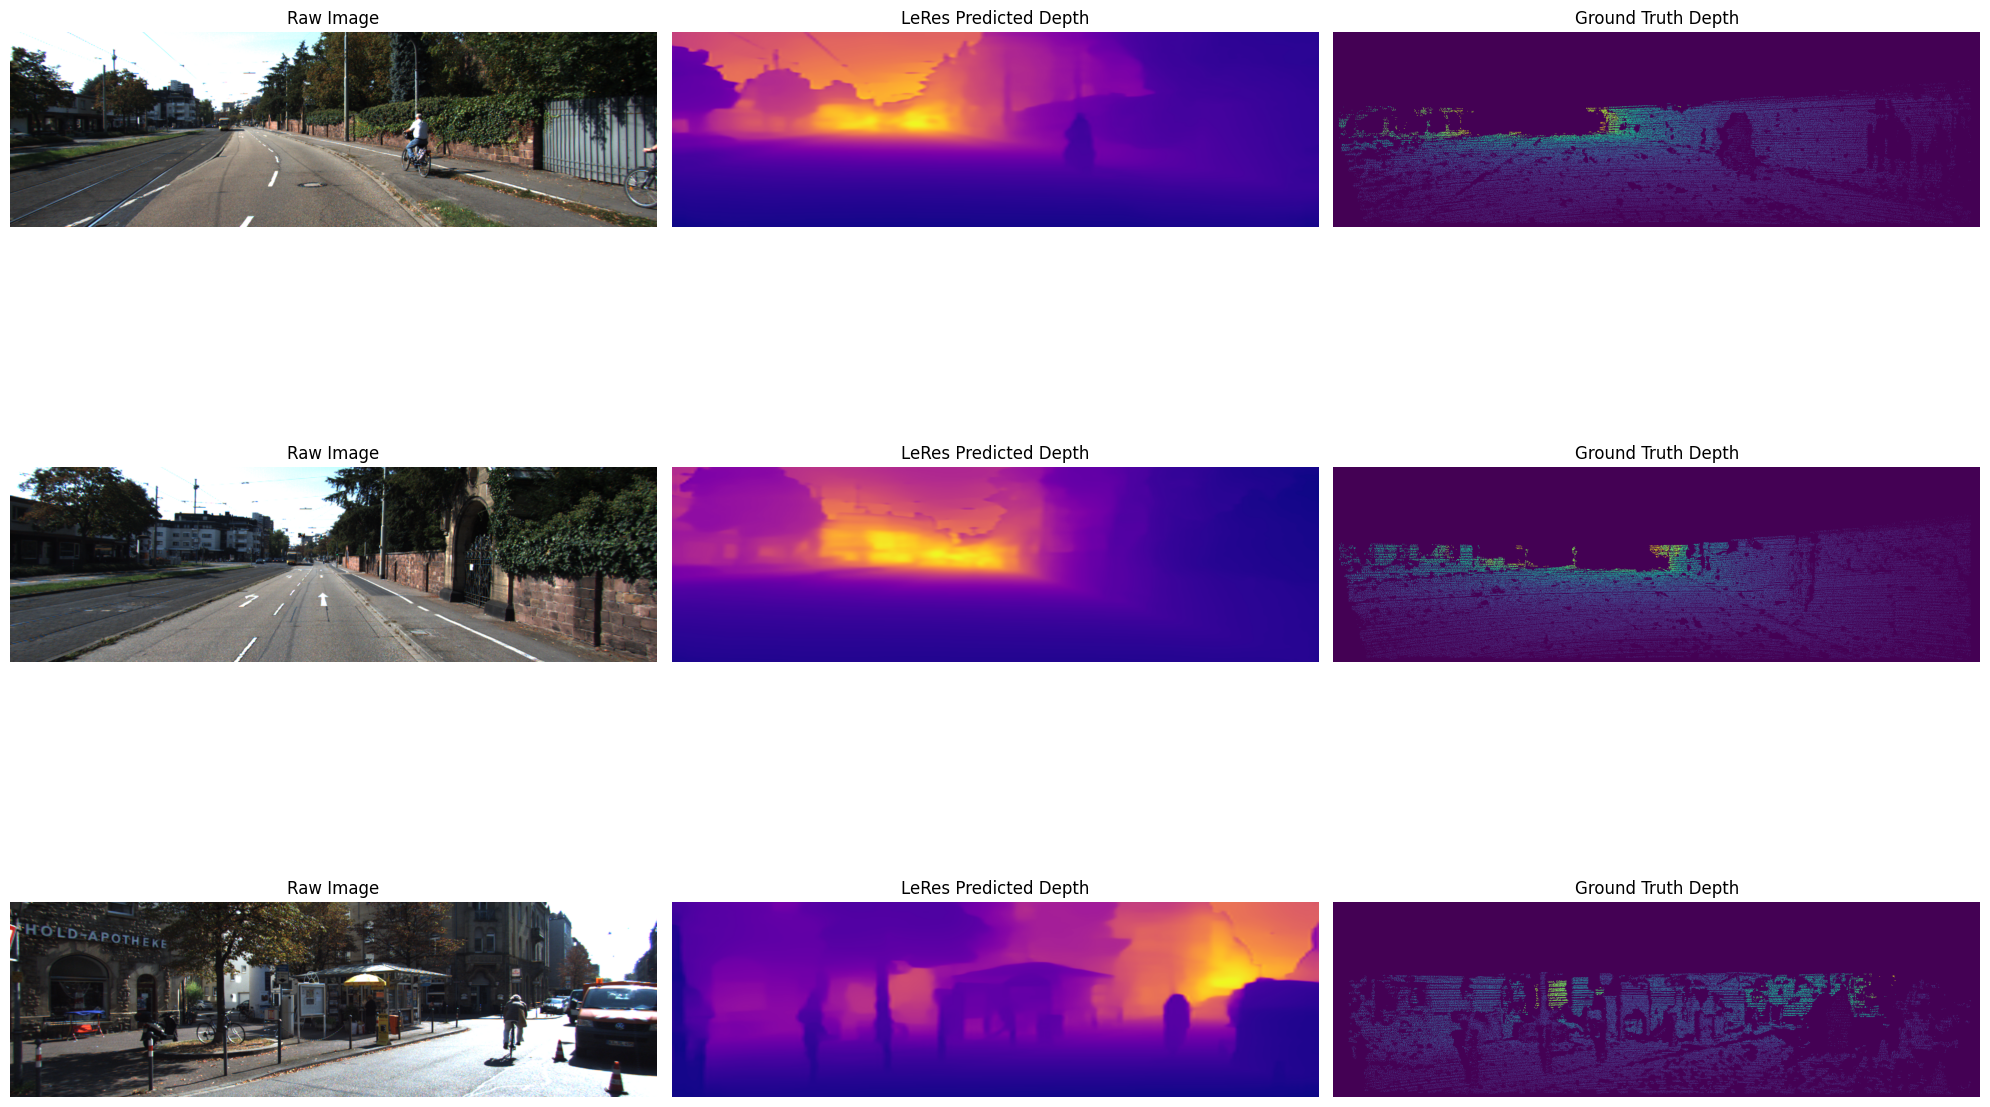

In [107]:
import os

fig = plt.figure(figsize=(20, 5*num_examples))
pic_path = "D:/AdelaiDepth/LeReS/Minist_Test/test_images/outputs"
pics = os.listdir(pic_path)
pics_raw = [os.path.join(pic_path, pic) for pic in pics if len(pic.split("-")) <= 1]
pics_depth = [os.path.join(pic_path, pic) for pic in pics if "depth" in pic and "depth_raw" not in pic]

num_examples = 3
for i in range(num_examples):

    raw_image = Image.open(pics_raw[i])

    prediction = Image.open(pics_depth[i])

    ground_truth = Image.open(gd_paths[i])



    ax = fig.add_subplot(num_examples, 3, i*3+1)
    ax.imshow(raw_image)
    ax.set_title("Raw Image")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+2)
    ax.imshow(prediction)
    ax.set_title("LeRes Predicted Depth")
    ax.axis('off')

    ax = fig.add_subplot(num_examples, 3, i*3+3)
    ax.imshow(ground_truth)
    ax.set_title("Ground Truth Depth")
    ax.axis('off')
plt.tight_layout()
plt.show()